In [183]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA

PATH = "clean_data_MSK.csv"
data = pd.read_csv(PATH, sep=':')
data = data[(data['long'] < 37.9545100) & (data['long'] > 37.1813900) & (data['lat'] < 55.9825000) & (data['lat'] > 55.1339600)].copy()
data.head(2)

lighting        lat       long                     region  \
0  Светлое время суток  55.616777  37.706516  Орехово-Борисово Северное   
1  Светлое время суток  55.841157  37.489332                Головинский   

            category                 date severity  dead  injured  \
0  Наезд на пешехода  2020-03-24 13:06:00   Легкий     0        1   
1       Столкновение  2018-09-15 11:00:00   Легкий     0        1   

   n_participants  ... Пешеходы  Другое  Эксплуатация  Нарушения при движении  \
0               2  ...        0       0             0                       0   
1               2  ...        0       0             0                       0   

   Нарушение правил подачи/приема сигналов  Не пострадал  Легкие травмы  \
0                                        0             0              0   
1                                        0             0              0   

   Скончался после госпитализации  Ранения  Скончался до госпитализации  
0                               0        1                            0  
1                               0        0                            0  

[2 rows x 99 columns]

### Embeddings constraction based on time series:

In [184]:
time2risk = [0.1168, 0.1174, 0.1564, 0.1296, 0.1153, 0.1293, 0.0963, 0.0562,
             0.029 , 0.0364, 0.0353, 0.0406, 0.0407, 0.0366, 0.0343, 0.0351,
             0.0352, 0.0393, 0.0447, 0.0515, 0.0494, 0.0573, 0.0778, 0.0762]

In [185]:
new_embeddings = data[['date']].copy()

day_time = data['date'].apply(lambda x: int(x.split()[1][:2])).copy()
new_embeddings["death_risk"] = [time2risk[time] for time in day_time]
new_embeddings["inAccident_risk"] = [1 if 2<=time<=6 else ( 3 if 13<=time<=21 else 2) for time in day_time]

del new_embeddings["date"]

new_embeddings.head(5)

death_risk  inAccident_risk
0      0.0366                3
1      0.0406                2
2      0.0573                3
3      0.0447                3
4      0.0406                2

### Binary-encoded values and their preprocessing 

In [186]:
cols = ['lighting', 'lat', 'long', 'region', 'category', 'date', 'severity',
       'dead', 'injured', 'n_participants', 'dr_exp', 'w_percent',
       'Температура выше +30С', 'Пасмурно', 'Туман', 'Снегопад',
       'Температура ниже -30С', 'Дождь', 'Ураганный ветер', 'Ясно', 'Метель',
       'Сужение проезжей части, наличие препятствий, затрудняющих движение транспортных средств',
       'Низкие сцепные качества покрытия', 'Сухое',
       'Свежеуложенная поверхностная обработка',
       'Отсутствие временных ТСОД в местах проведения работ',
       'Иные недостатки',
       'Отсутствие элементов обустройства остановочного пункта общественного пассажирского транспорта',
       'Мокрое', 'Залитое (покрытое) водой', 'Неисправное освещение',
       'Недостатки зимнего содержания', 'Отсутствие освещения',
       'Отсутствие дорожных знаков в необходимых местах',
       'Несоответствие дорожных ограждений предъявляемым требованиям',
       'Отсутствие направляющих устройств и световозвращающих элементов на них',
       'Отсутствие дорожных ограждений в необходимых местах',
       'Обработанное противогололедными материалами',
       'Недостаточное освещение', 'Нарушения в размещении наружной рекламы',
       'Со снежным накатом', 'Загрязненное', 'Не установлено',
       'Неправильное применение, плохая видимость дорожных знаков',
       'Неудовлетворительное состояние обочин', 'Заснеженное',
       'Ограничение видимости', 'Неисправность светофора',
       'Плохая видимость световозвращателей, размещенных на дорожных ограждениях',
       'Отсутствие, плохая различимость горизонтальной разметки проезжей части',
       'Отсутствие пешеходных ограждений в необходимых местах',
       'Плохая видимость светофора',
       'Несоответствие люков смотровых колодцев и ливневой канализации предъявляемым требованиям',
       'Пыльное', 'Неудовлетворительное состояние разделительной полосы',
       'Неровное покрытие', 'Дефекты покрытия',
       'Отсутствие, плохая различимость вертикальной разметки',
       'Отсутствие тротуаров (пешеходных дорожек)', 'Гололедица',
       'Несоответствие железнодорожного переезда предъявляемым требованиям',
       'Грузовые автомобили', 'Легковые автомобили (представительские)',
       'Специализированные машины', 'Прочие ТС', 'Легковые автомобили',
       'Общественный транспорт', 'Мототранспортные средства',
       'Водитель Эксплуатация', 'Водитель Нарушения при движении',
       'Водитель Пешеходы',
       'Водитель Нарушение правил эксплуатации мототранспорта',
       'Водитель Нарушение правил безопасности при управлении',
       'Водитель Нарушение правил перевозки людей/грузов', 'Водитель Другое',
       'Водитель Нарушение правил подачи/приема сигналов',
       'Регулируемые перекрестки', 'Регулируемые пешеходные переходы',
       'Эстакада/Мост/Тоннель', 'Места скопления автотранспорта',
       'Нерегулируемые пешеходные переходы', 'Места скопления людей',
       'Нерегулируемые перекрестки', 'Иные объекты', 'Эксплуатация',
       'Нарушение правил подачи/приема сигналов', 'Другое',
       'Нарушения при движении', 'Пешеходы']

sample = data[cols].iloc[:, 12:]
sample.head()

Температура выше +30С  Пасмурно  Туман  Снегопад  Температура ниже -30С  \
0                      0         0      0         0                      0   
1                      0         1      0         0                      0   
2                      0         1      0         0                      0   
3                      0         0      0         0                      0   
4                      0         0      0         0                      0   

   Дождь  Ураганный ветер  Ясно  Метель  \
0      0                0     1       0   
1      0                0     0       0   
2      0                0     0       0   
3      0                0     1       0   
4      0                0     1       0   

   Сужение проезжей части, наличие препятствий, затрудняющих движение транспортных средств  \
0                                                  0                                         
1                                                  0                                         
2                                                  0                                         
3                                                  0                                         
4                                                  0                                         

   ...  Места скопления автотранспорта  Нерегулируемые пешеходные переходы  \
0  ...                               0                                   0   
1  ...                               1                                   0   
2  ...                               1                                   1   
3  ...                               0                                   0   
4  ...                               1                                   0   

   Места скопления людей  Нерегулируемые перекрестки  Иные объекты  \
0                      0                           0             1   
1                      0                           0             1   
2                      0                           0             1   
3                      1                           0             1   
4                      0                           0             1   

   Эксплуатация  Нарушение правил подачи/приема сигналов  Другое  \
0             0                                        0       0   
1             0                                        0       0   
2             0                                        0       0   
3             0                                        0       0   
4             0                                        0       0   

   Нарушения при движении  Пешеходы  
0                       0         0  
1                       0         0  
2                       0         0  
3                       0         0  
4                       0         0  

[5 rows x 77 columns]

TSNE visualisation

In [187]:
# select indeces to be printed
idx2plot = np.random.choice(np.arange(len(sample)), 
                            size=25000,
                            replace=False)

# select objects based on indeces
y = np.where(data.dead.values==0, 0, 1)[idx2plot]
idx_dead = np.unique(np.arange(len(y)) * y)[1:]
idx_injured = np.unique(np.arange(len(y)) * (-1 * y + 1))[1:]

# make a slice of the given dataset based on indeces
dataset = sample.values[idx2plot]

In [188]:
from sklearn.manifold import TSNE

tsne = TSNE()
x = tsne.fit_transform(dataset)

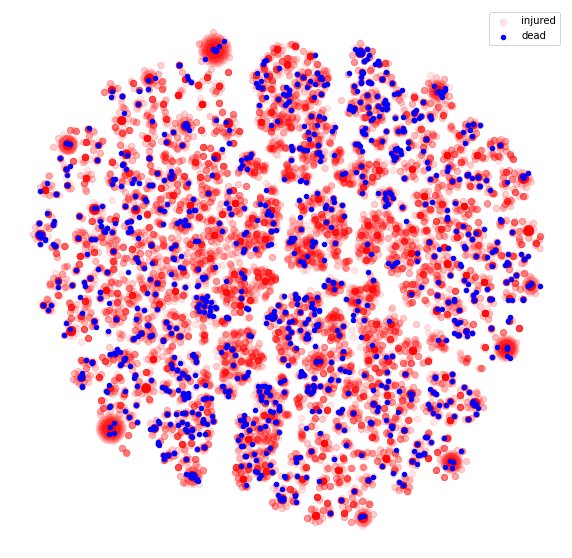

In [198]:
plt.figure(figsize=(10, 10))
plt.scatter(x[idx_injured, 0], x[idx_injured, 1], c='r',  s=40, alpha=0.1, label='injured')
plt.scatter(x[idx_dead, 0], x[idx_dead, 1], c='b', s=20, label='dead')
plt.axis('off')
plt.legend()
plt.savefig("imgs/TSNE.svg", facecolor='white', pad_inches=0.01)
plt.savefig("imgs/TSNE.png", facecolor='white', pad_inches=0.01)
plt.show()

## Plotting correlation 
### 1. without undersamplig

In [200]:
n_components=10
columns = [f'F{i+1}' for i in range(n_components)]

# performing PCA
pca = PCA(n_components=n_components)
pca_transformed = pca.fit_transform(sample.values)
pca_transformed = pd.DataFrame(columns=columns, data=pca_transformed)

In [201]:
X = pd.concat([pca_transformed, new_embeddings], axis=1)
y = data['dead'].apply(lambda x: 0 if x==0 else 1)

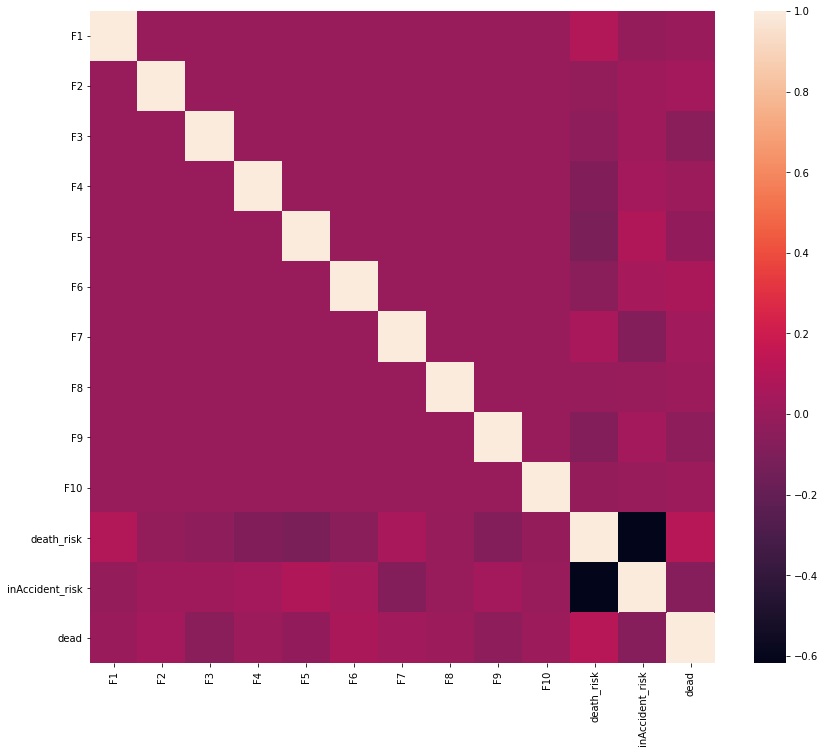

In [207]:
plt.figure(figsize=(14, 12))
sns.heatmap(pd.concat([X, y], axis=1).corr())

plt.savefig("imgs/heatmap.svg", facecolor='white', pad_inches=0.01)
plt.savefig("imgs/heatmap.png", facecolor='white', pad_inches=0.01)
plt.show()

### 1. with undersamplig

In [208]:
X.shape, y.shape

((54559, 12), (54559,))

In [209]:
from imblearn.under_sampling import RandomUnderSampler

# performing undersampling
rus = RandomUnderSampler()
X_undersample, y_undersample = rus.fit_resample(X, y)

corr = pd.concat([X_undersample, y_undersample], axis=1).corr()
corr[['dead']].abs().sort_values(by='dead', ascending=False)

dead
dead             1.000000
death_risk       0.220472
F6               0.156323
inAccident_risk  0.145663
F3               0.137094
F2               0.107658
F9               0.092618
F5               0.067684
F7               0.046684
F10              0.032079
F4               0.029642
F8               0.023770
F1               0.000360

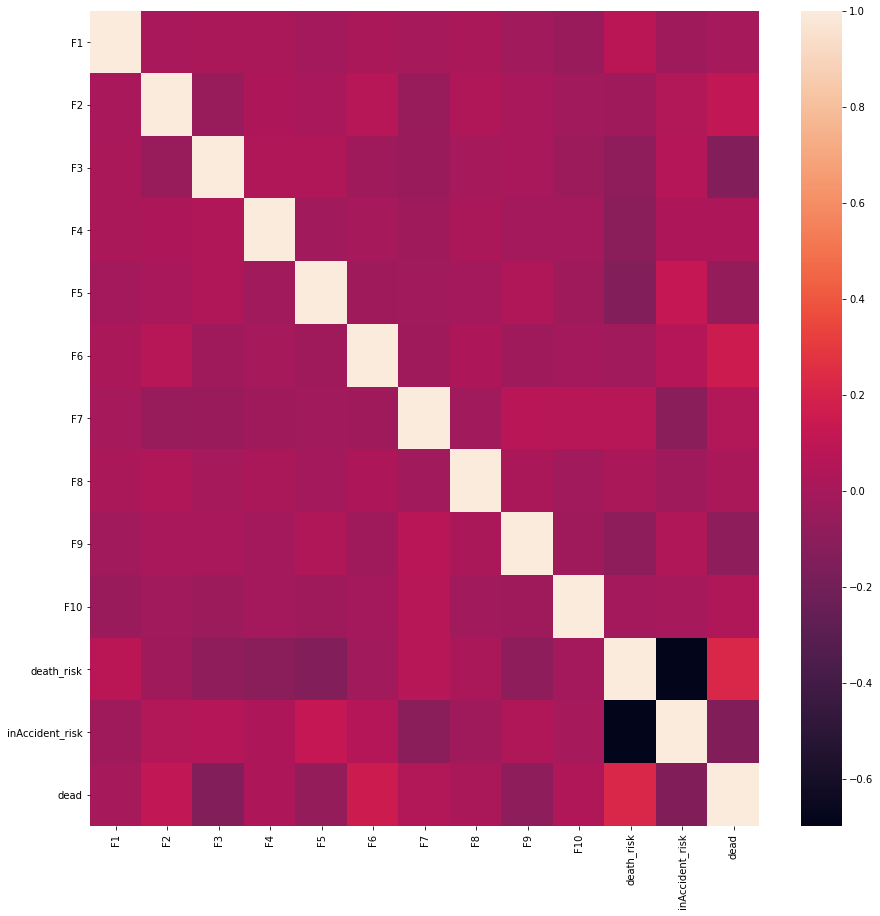

In [210]:
plt.figure(figsize=(15, 15))
sns.heatmap(corr)

plt.savefig("imgs/heatmap2.svg", facecolor='white', pad_inches=0.01)
plt.savefig("imgs/heatmap2.png", facecolor='white', pad_inches=0.01)
plt.show()

In [108]:
X = pd.concat([sample, new_embeddings], axis=1)
y = data['dead'].apply(lambda x: 0 if x==0 else 1)
X.shape, y.shape

((54559, 79), (54559,))

In [181]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, ADASYN, SVMSMOTE

In [182]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, accuracy_score, average_precision_score
from sklearn.metrics import cohen_kappa_score as CKS 

X = pd.concat([sample, new_embeddings], axis=1)
y = data['dead'].apply(lambda x: 0 if x==0 else 1)

print('before undersample:', X.shape, y.shape)
X_tr,  X_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.3)

smote = SVMSMOTE(sampling_strategy=0.6,
            k_neighbors=5,
            n_jobs=-1)
X_tr, y_tr = smote.fit_resample(X_tr, y_tr)

rus = RandomUnderSampler(sampling_strategy=0.7)
X_tr, y_tr = rus.fit_resample(X_tr, y_tr)

print('after undersample:', X_tr.shape, y_tr.shape, (y_tr.sum(),))

before undersample: (54559, 79) (54559,)
after undersample: (52986, 79) (52986,) (21818,)


In [177]:
from catboost import CatBoostClassifier

In [178]:
cbc = CatBoostClassifier(verbose=True)
cbc.fit(X_tr, y_tr)

4.17s
614:	learn: 0.2240679	total: 6.65s	remaining: 4.16s
615:	learn: 0.2239415	total: 6.66s	remaining: 4.15s
616:	learn: 0.2238571	total: 6.67s	remaining: 4.14s
617:	learn: 0.2237797	total: 6.68s	remaining: 4.13s
618:	learn: 0.2237743	total: 6.69s	remaining: 4.12s
619:	learn: 0.2236735	total: 6.7s	remaining: 4.11s
620:	learn: 0.2236718	total: 6.71s	remaining: 4.1s
621:	learn: 0.2236130	total: 6.72s	remaining: 4.09s
622:	learn: 0.2235733	total: 6.74s	remaining: 4.08s
623:	learn: 0.2235551	total: 6.75s	remaining: 4.07s
624:	learn: 0.2234678	total: 6.76s	remaining: 4.05s
625:	learn: 0.2233846	total: 6.77s	remaining: 4.04s
626:	learn: 0.2233824	total: 6.78s	remaining: 4.03s
627:	learn: 0.2233044	total: 6.79s	remaining: 4.02s
628:	learn: 0.2232556	total: 6.8s	remaining: 4.01s
629:	learn: 0.2232243	total: 6.82s	remaining: 4s
630:	learn: 0.2231984	total: 6.83s	remaining: 4s
631:	learn: 0.2231679	total: 6.84s	remaining: 3.98s
632:	learn: 0.2231661	total: 6.86s	remaining: 3.97s
633:	learn: 0.2

In [174]:
accuracy_score(y_ts, cbc.predict(X_ts)), CKS(y_ts, cbc.predict(X_ts))

(0.9444648093841642, 0.057143454638048874)